### Main file for calibration ###

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
from Calibration import Calib_position

a1 = 0.07393303257472039 +/- 0.04317233867630477
b1 = -5.781359381406985 +/- 1.4968254809143566
c1 = 3467.0331440893037 +/- 11.427792661461284
a2 = 0.09815971073152496 +/- 0.05600997796137778
b2 = -7.069392287744716 +/- 1.9955386885861701
c2 = 3696.678977821601 +/- 16.082847330759794
a3 = 0.0810757661180761 +/- 0.04137672889897555
b3 = -6.824551311042239 +/- 1.4781030095325272
c3 = 3918.7580004383944 +/- 11.71753974489636
a1 = 0.06985206962898116 +/- 0.045454845136250345
b1 = -2.336671480387364 +/- 1.5952413920153303
c1 = 3354.4762191746568 +/- 12.619862209417837
a2 = 0.11543988002369376 +/- 0.04189259538267817
b2 = -3.539367613072029 +/- 1.4843525302073861
c2 = 3579.4274579093253 +/- 11.684115642436298
a3 = 0.16133717334600084 +/- 0.06769320318746051
b3 = -4.989475745965243 +/- 2.4242801338404
c3 = 3803.1414549083033 +/- 19.149899203376165
a1 = 0.08873410727976239 +/- 0.05186341980947258
b1 = -4.1992452624222505 +/- 1.8455444076356338
c1 = 3433.270072188001 +/- 14.584058272489223
a2 =

d:\GSI\SHIP\Calibration.py:177: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,8))


a1 = 0.09206081737265626 +/- 0.043138662713705506
b1 = -4.6717116270068395 +/- 1.4998835193319708
c1 = 3425.314349126042 +/- 11.451621261438273
a2 = 0.11198831509067642 +/- 0.04743194639615728
b2 = -5.3183896520149725 +/- 1.629223421727106
c2 = 3647.7417778444046 +/- 12.380185920527403
a3 = 0.04515842777568535 +/- 0.04524249330933461
b3 = -3.3533665478268553 +/- 1.5936165266333906
c3 = 3853.9791470495493 +/- 12.379902988863074
a1 = 0.04210563318147742 +/- 0.059745897858807226
b1 = -4.227175765253445 +/- 2.101009265035473
c1 = 3426.402922946305 +/- 16.530962981887416
a2 = 0.15650024546903385 +/- 0.06727476585627999
b2 = -8.160126258254307 +/- 2.3408845994004652
c2 = 3670.588321213451 +/- 17.975079323537052
a3 = 0.002553564332300584 +/- 0.04625960570301615
b3 = -3.262375510879484 +/- 1.6386246773405855
c3 = 3854.05739518448 +/- 12.83219283697619
a1 = 0.07613746696114876 +/- 0.044228530914319074
b1 = -3.4426530741936077 +/- 1.5501744738576426
c1 = 3384.7271125224283 +/- 12.139625130171167

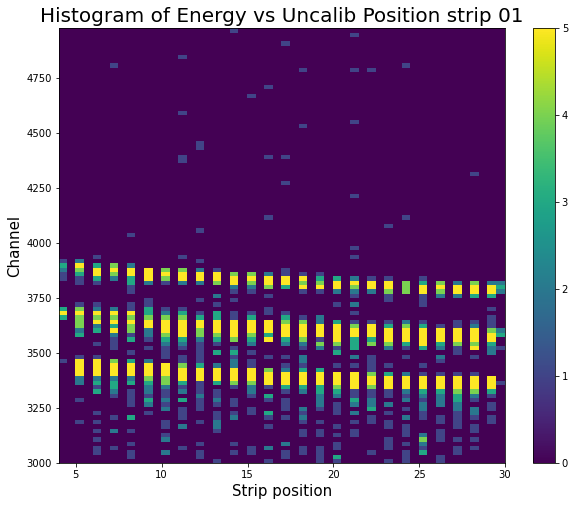

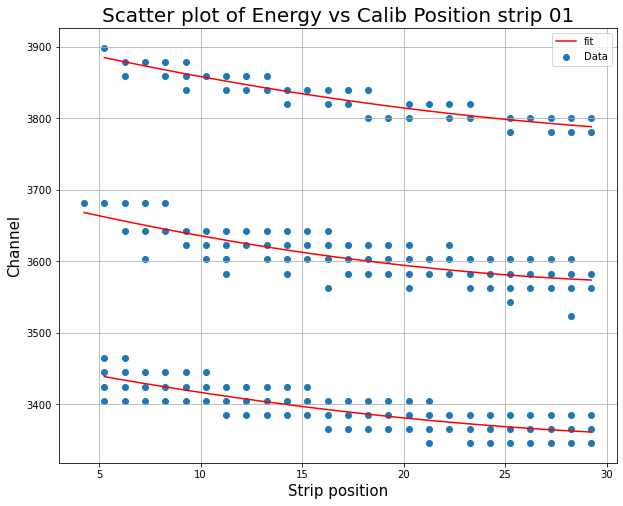

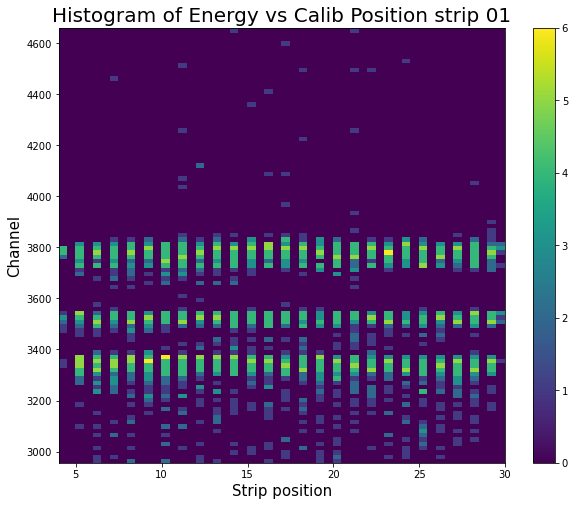

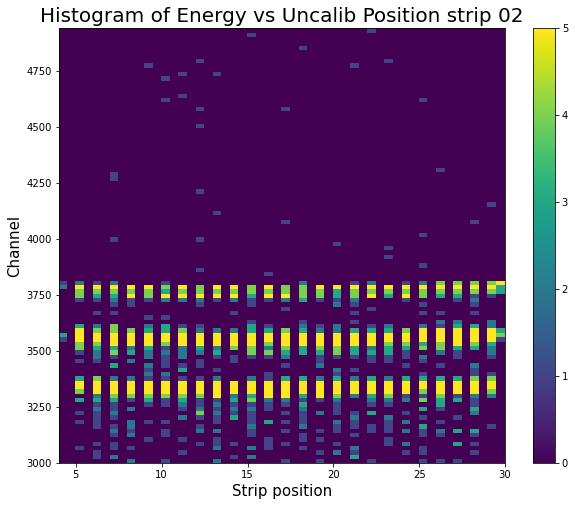

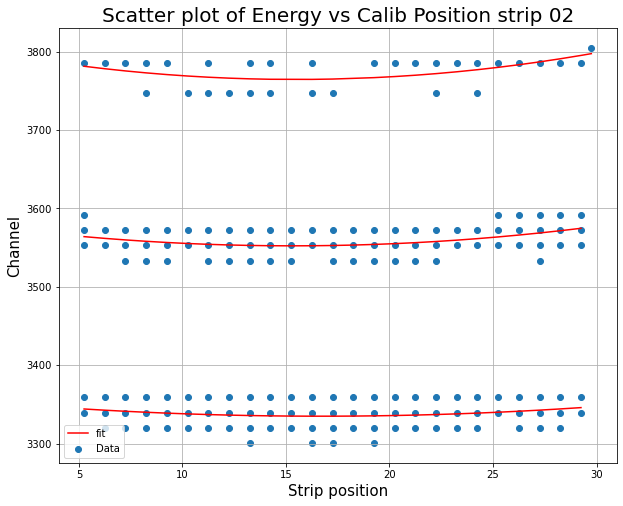

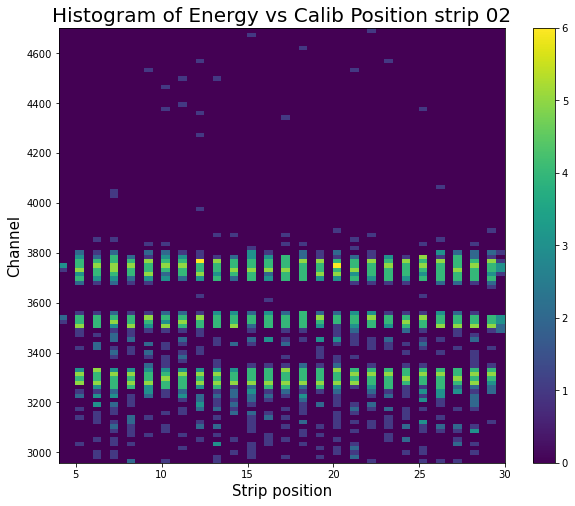

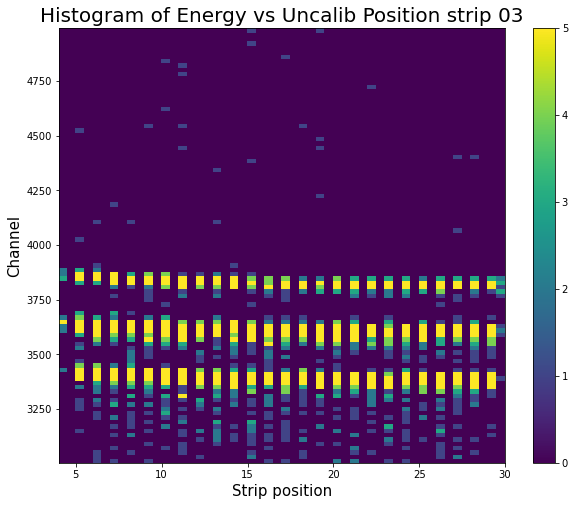

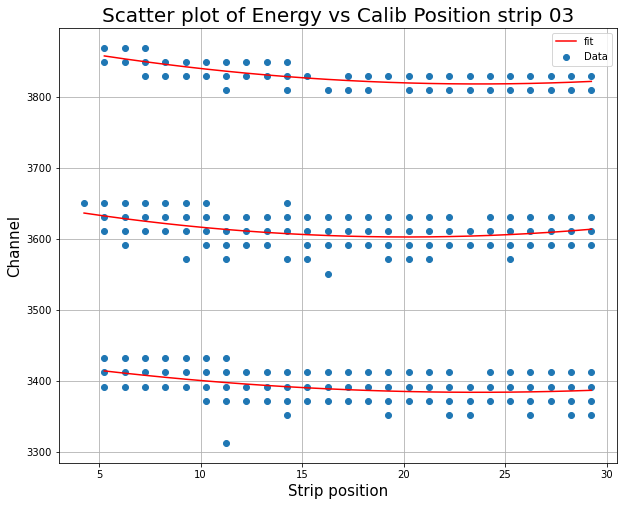

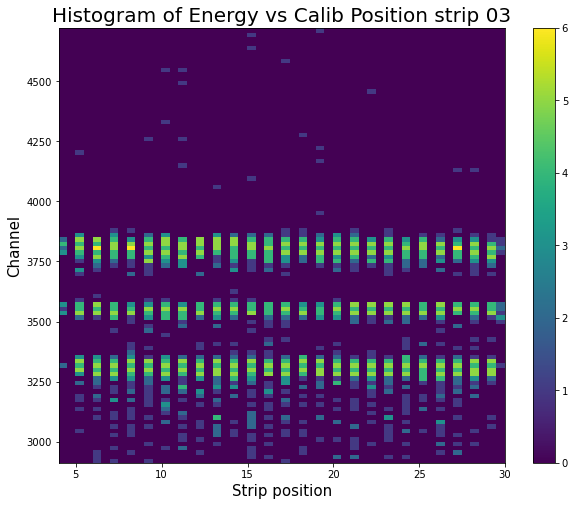

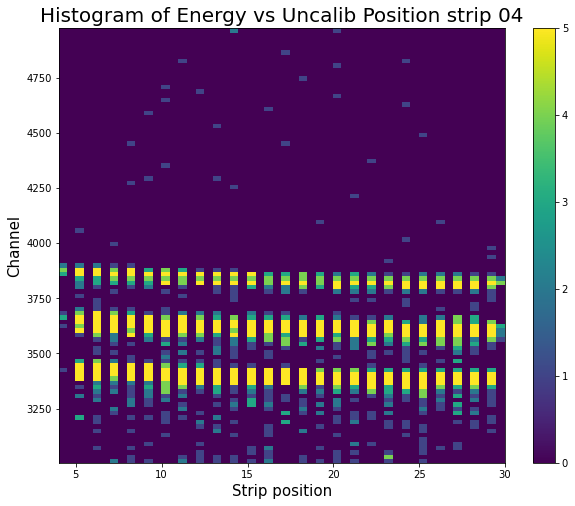

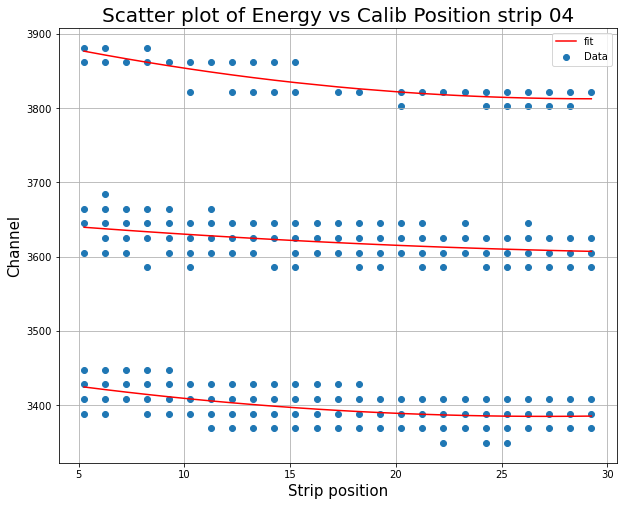

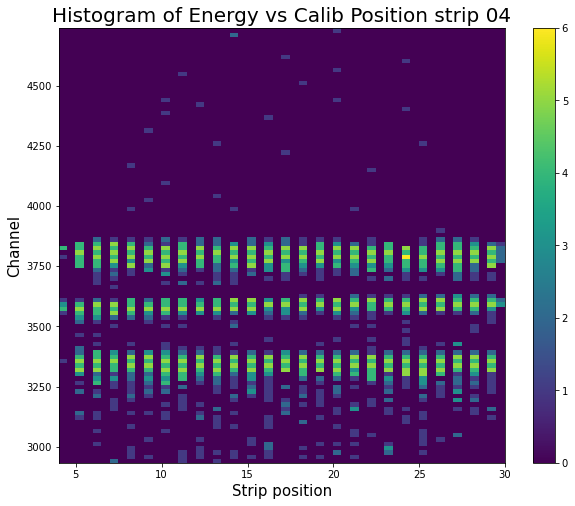

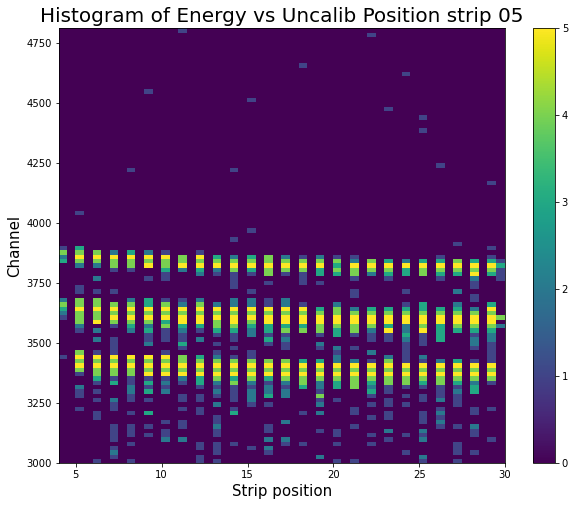

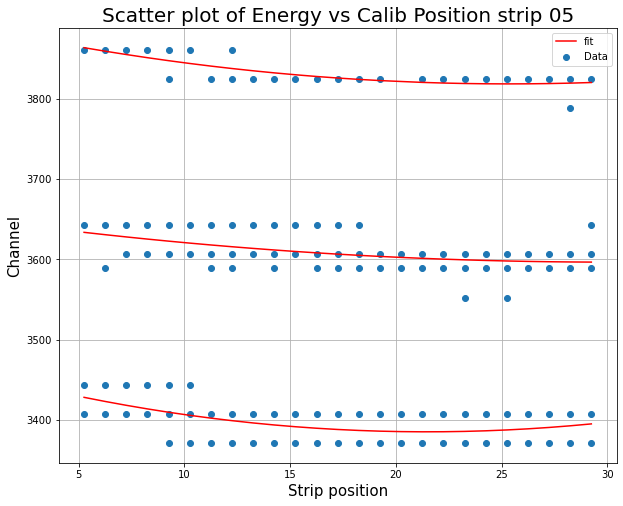

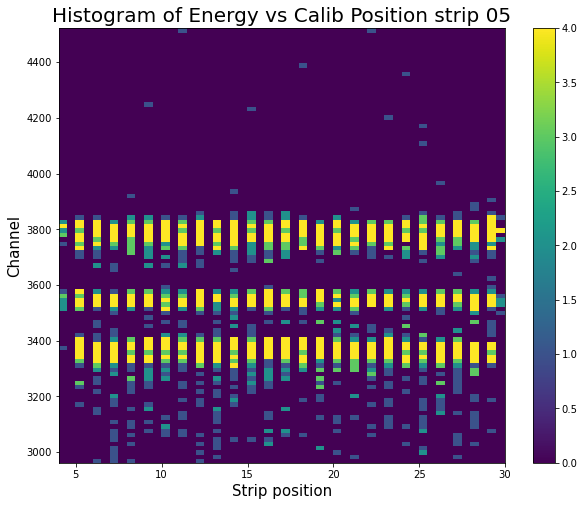

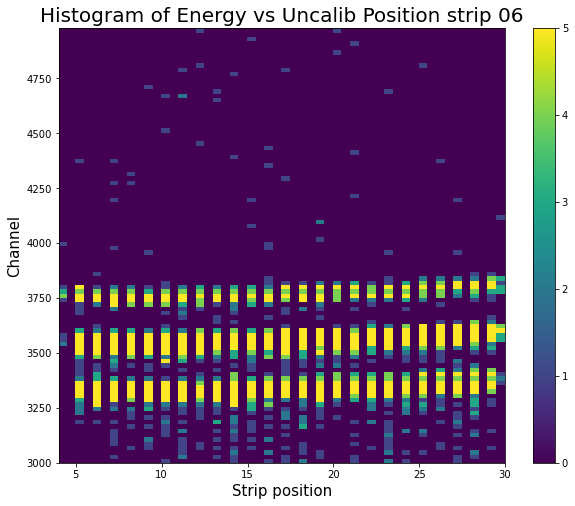

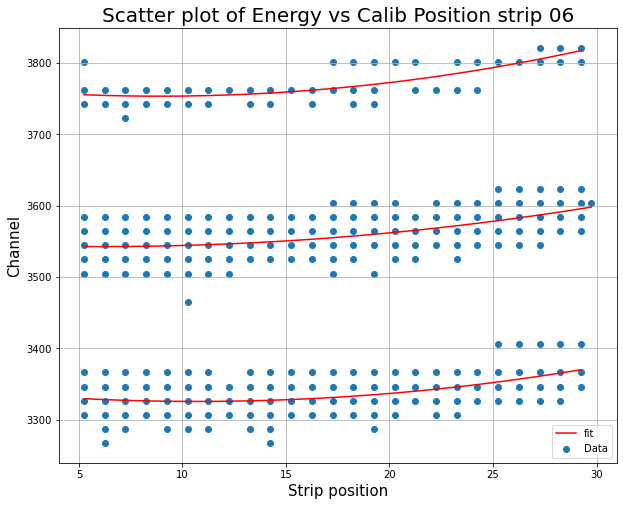

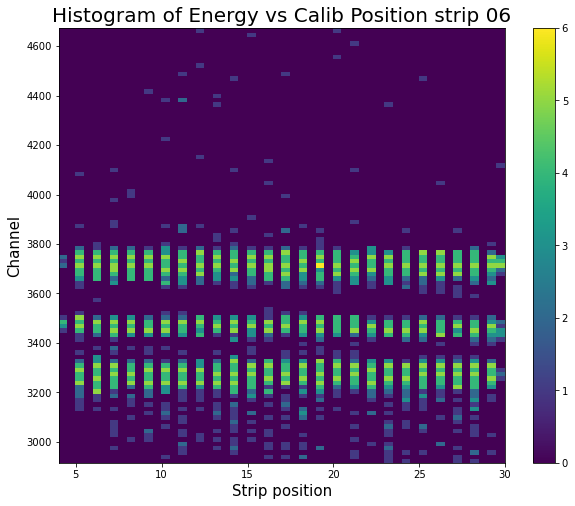

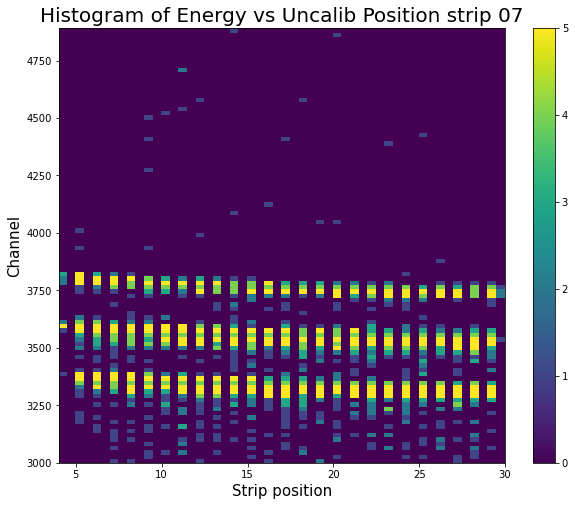

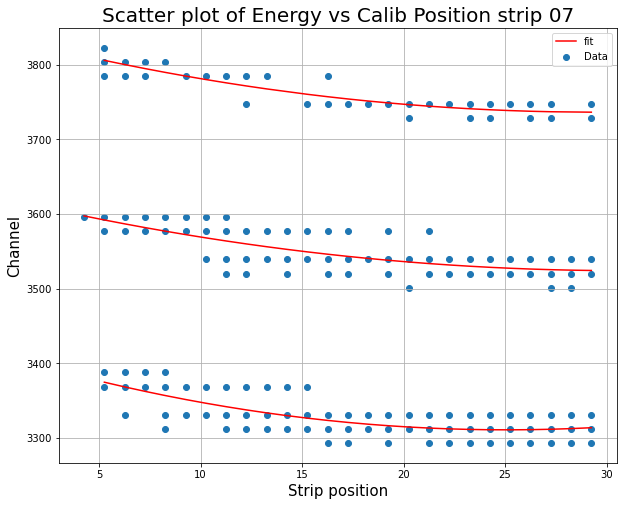

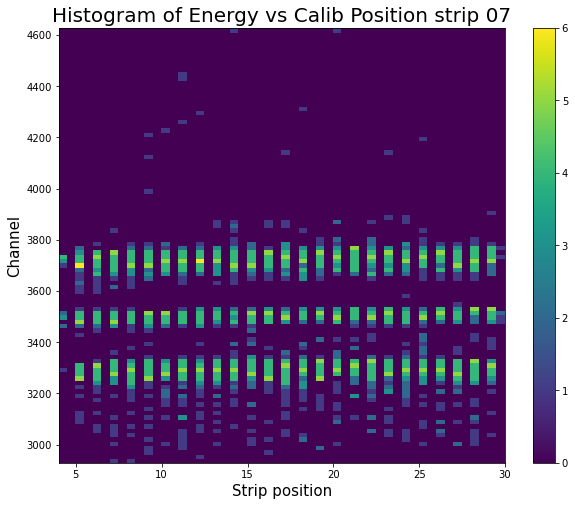

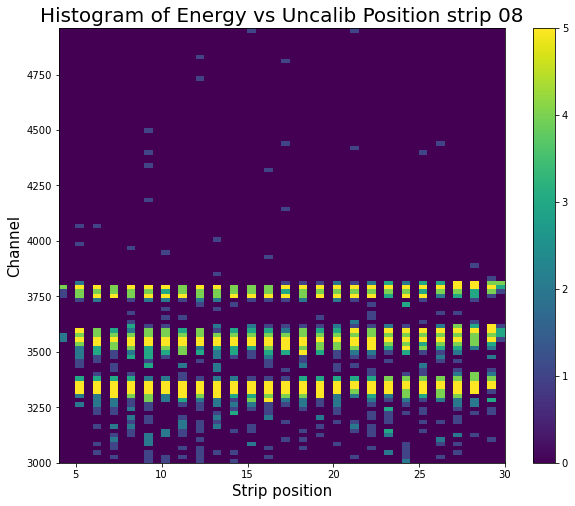

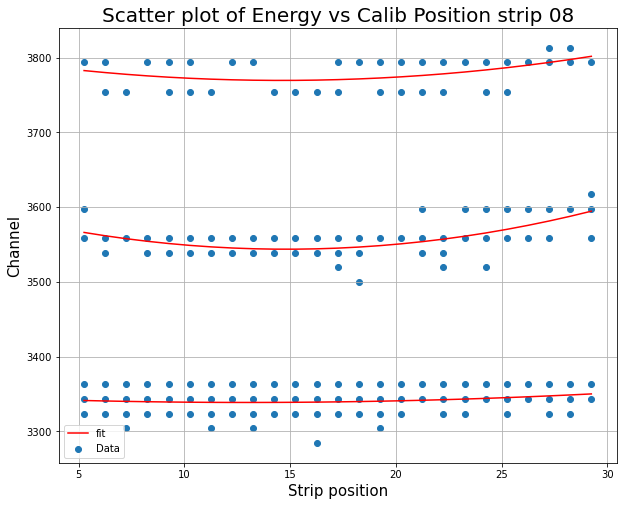

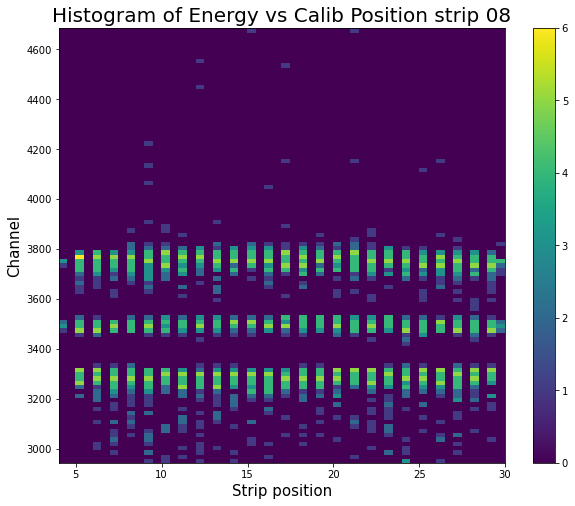

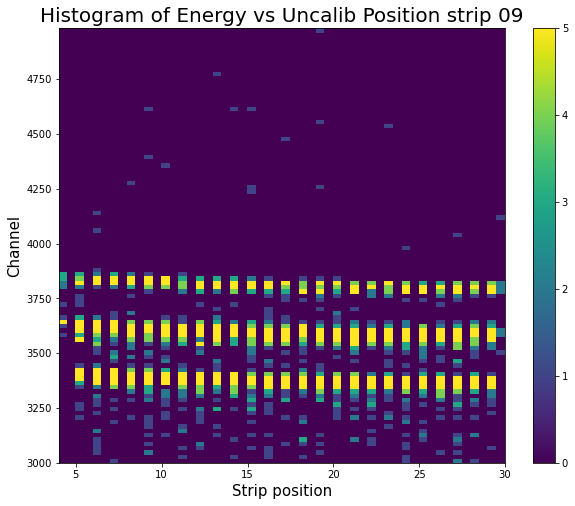

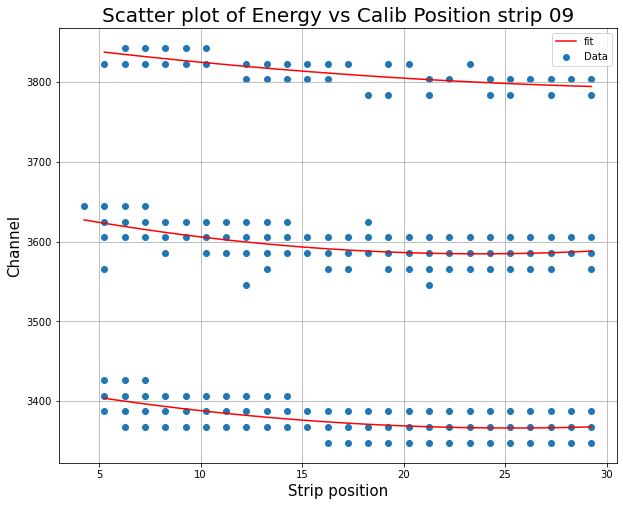

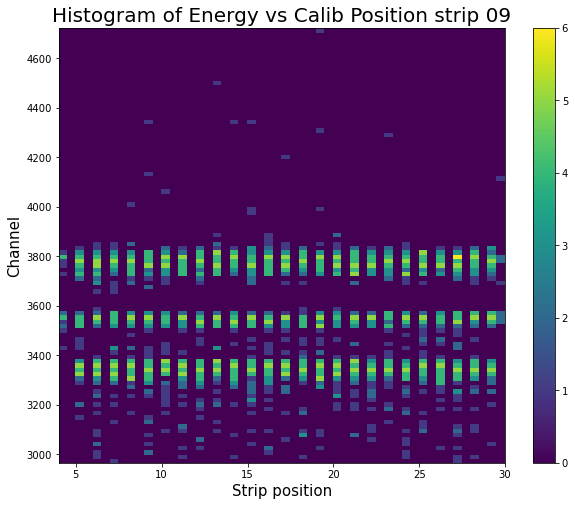

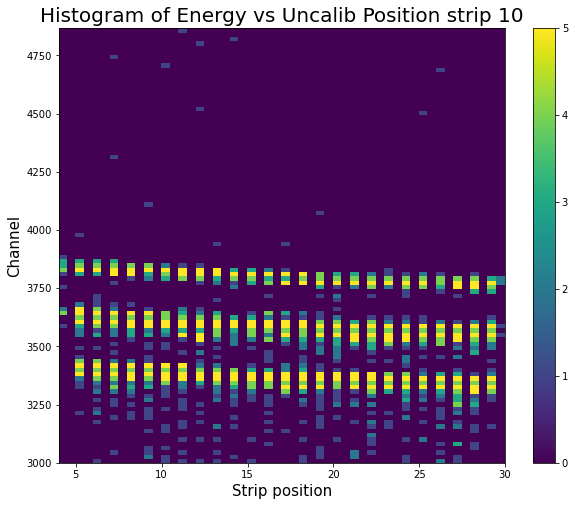

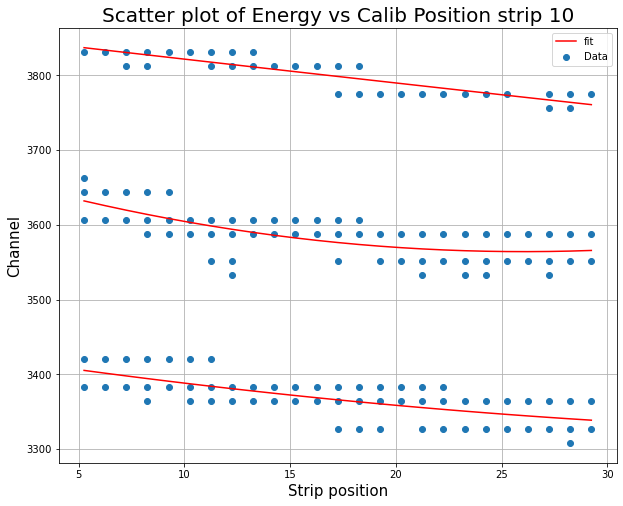

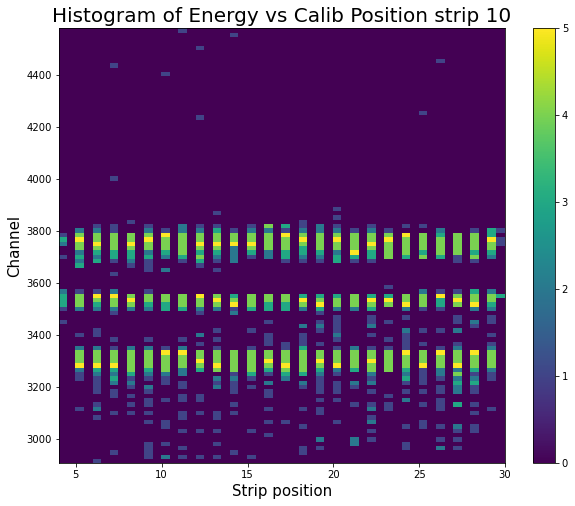

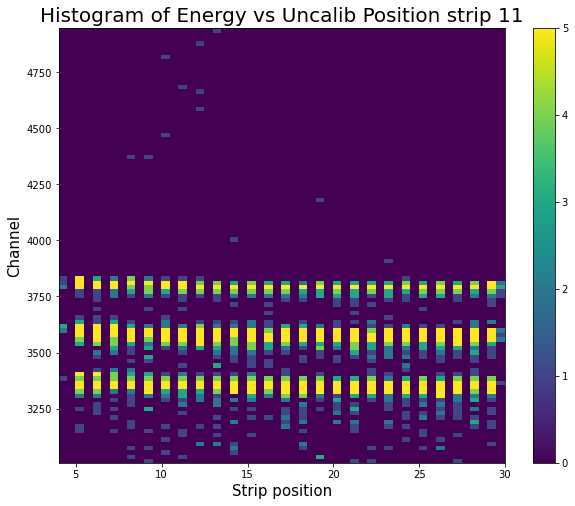

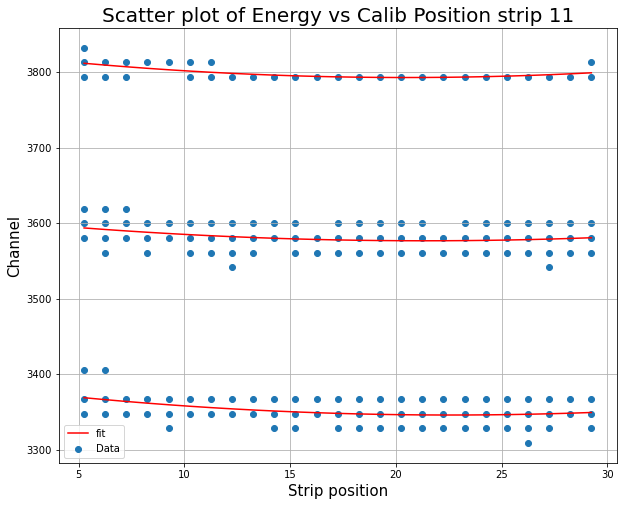

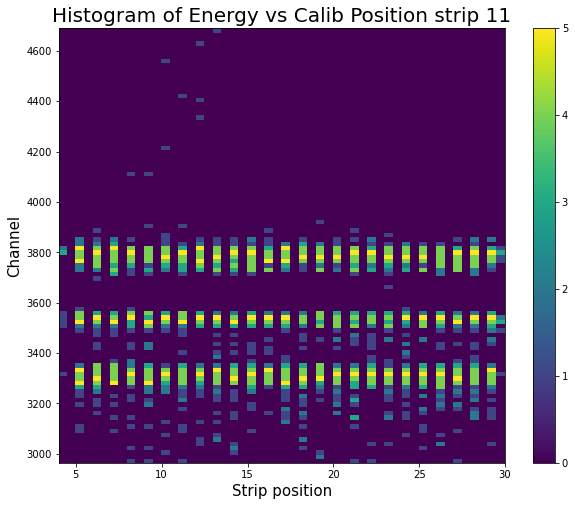

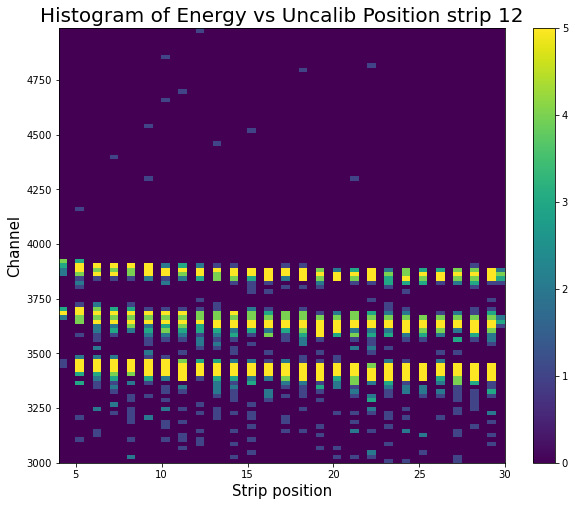

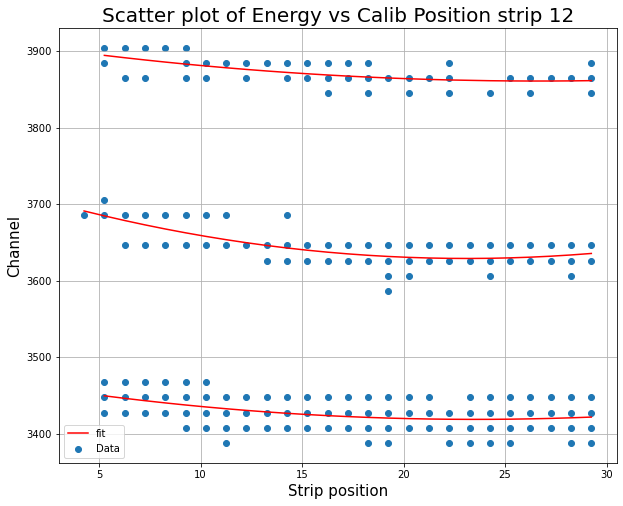

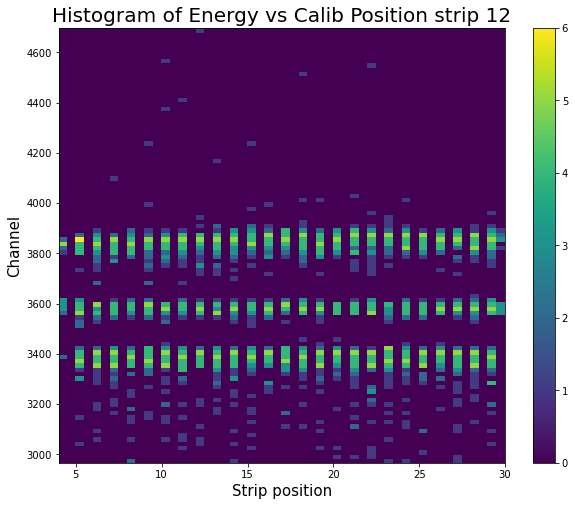

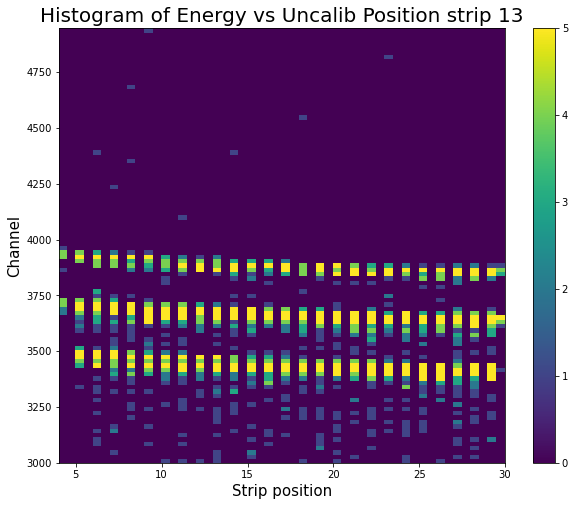

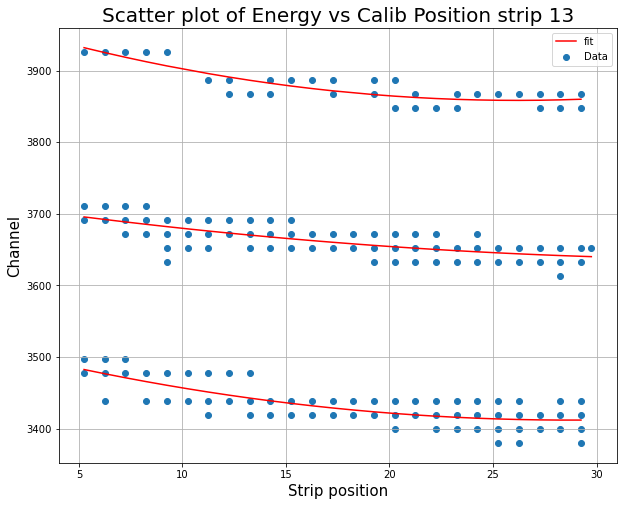

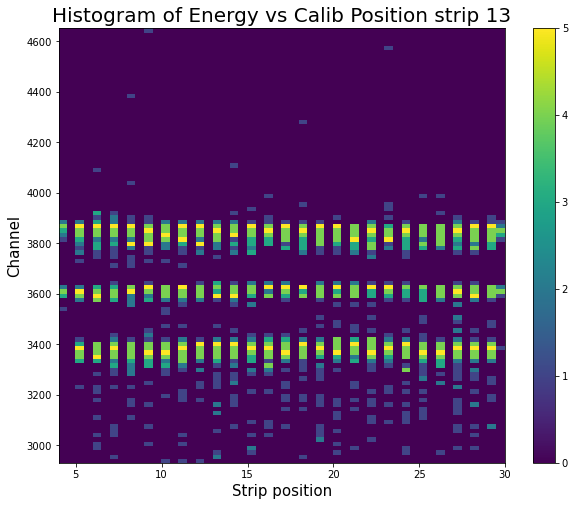

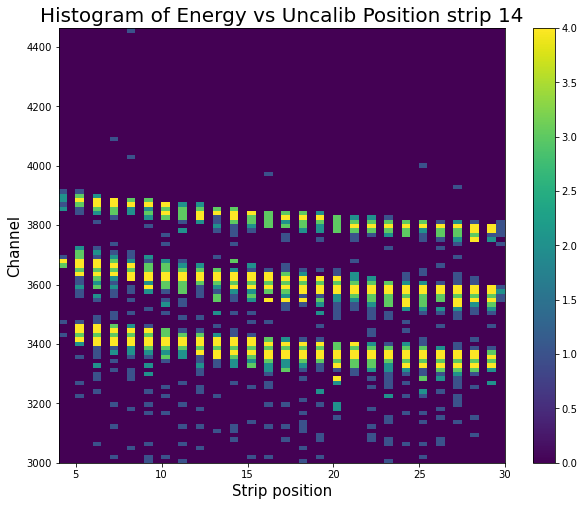

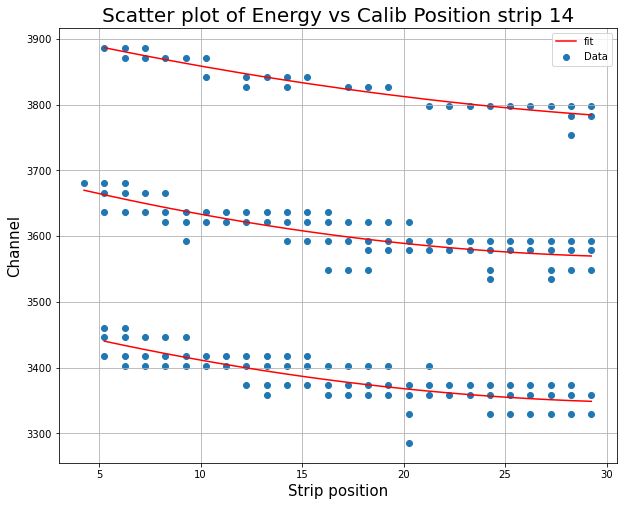

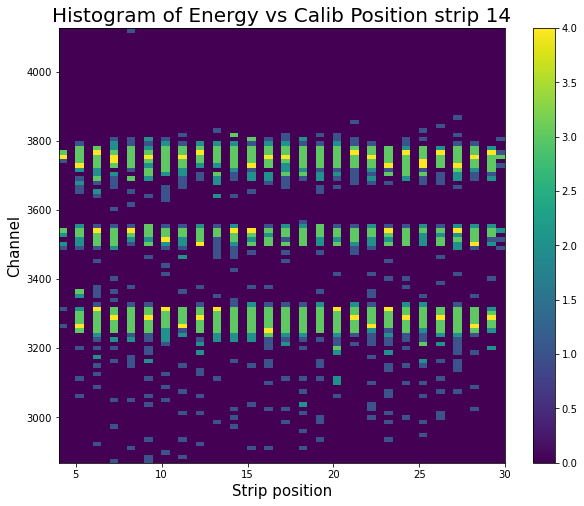

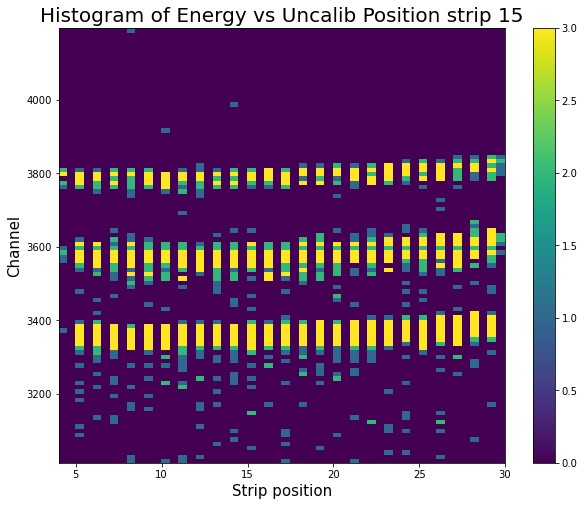

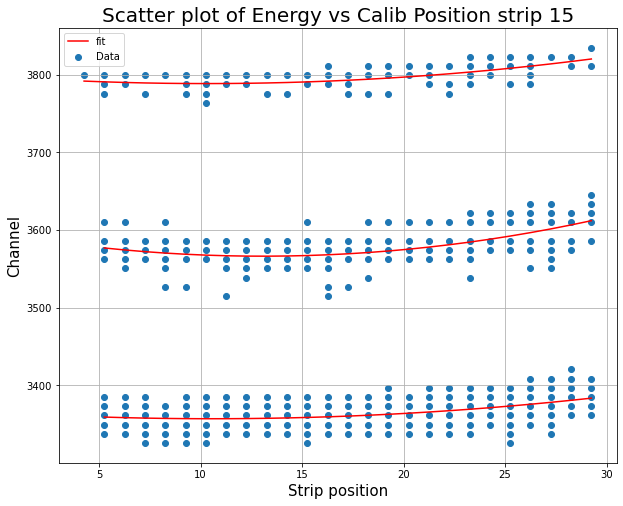

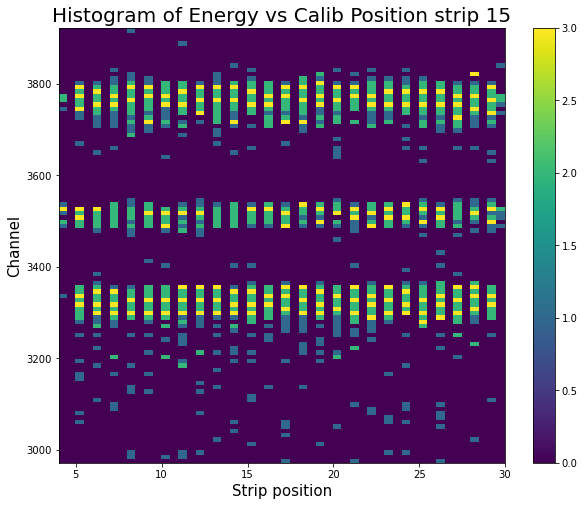

In [2]:
# note 1 : try to find a way to automatize the choice for lower bound and upper bound 

lower_bound = [3500, 3500, 3500, 3500, 3500, 3450, 3450, 3400, 3500, 3500, 3500, 3500, 3550, 3500, 3450] # seen from plot_data
upper_bound = [3700, 3700, 3700, 3700, 3700, 3700, 3700, 3700, 3700, 3700, 3700, 3800, 3800, 3700, 3700]

for ii in range(1,16):
    if ii<10:
        file = 'E vs Calib Postion top 0'+str(ii)+'.hdat'
        strip = '0'+str(ii)
    else:
        file = 'E vs Calib Postion top '+str(ii)+'.hdat'
        strip = str(ii)
    my_cal = Calib_position("# X ", "Y ")
    my_cal.read_data(file)
    my_cal.plot_hist(strip)
    my_cal.plot_data(strip)
    my_cal.fit_data(lower_bound[ii-1], upper_bound[ii-1], strip) 
    my_cal.fit_results()
    my_cal.write_txt('fit results', strip)
    my_cal.plot_calib_hist(lower_bound[ii-1], upper_bound[ii-1], strip)
